# Imports

In [1]:
!pip install -q "transformers>=4.40.0" datasets evaluate accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
bigframes 1

In [2]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c8847e5b2c29949a96f91bb6196d19e739231edc719bc377235952ed672b5794
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import email
from email.parser import Parser
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch, datetime, evaluate, logging
from datasets import Dataset, DatasetDict
from transformers import (
    T5TokenizerFast, T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
)

2025-05-10 15:04:34.262248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746889474.453937      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746889474.507271      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Analysis and Cleaning

In [4]:
df = pd.read_csv('/kaggle/input/enron-email-dataset/emails.csv')


print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (517401, 2)

Data types:
file       object
message    object
dtype: object

Missing values per column:
file       0
message    0
dtype: int64


In [5]:
print(df.head(5))

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


A very simple observation to separate original mail body was to look for the **first double line breaks**

In [6]:
def parse_email(message):
    try:

        subject_match = re.search(r'Subject: (.*?)(?:\n|$)', message)
        subject = subject_match.group(1).strip() if subject_match else ""
        
        parts = message.split('\n\n', 1)
        body = parts[1].strip() if len(parts) > 1 else ""
        
        return {
            'subject': subject,
            'body': body
        }
    except Exception as e:
        return {
            'subject': '',
            'body': f'Error parsing: {str(e)}'
        }

In [7]:
parsed_data = []
print("Parsing emails...")
for i in tqdm(range(len(df))):
    parsed = parse_email(df.iloc[i]['message'])
    parsed_data.append({
        'subject': parsed['subject'],
        'body': parsed['body']
    })

new_df = pd.DataFrame(parsed_data)


Parsing emails...


100%|██████████| 517401/517401 [00:13<00:00, 39468.04it/s]


In [8]:
print(new_df.head(5))

     subject                                               body
0                                          Here is our forecast
1        Re:  Traveling to have a business meeting takes the...
2   Re: test                     test successful.  way to go!!!
3             Randy,\n\n Can you send me a schedule of the s...
4  Re: Hello                  Let's shoot for Tuesday at 11:45.


In [9]:
# Remove Re:, FW:, and Fwd: prefixes from subjects
new_df['subject'] = new_df['subject'].str.replace(r'^(re|fw|fwd):\s*', '', regex=True, flags=re.IGNORECASE)

In [10]:
print(new_df.head(5))

  subject                                               body
0                                       Here is our forecast
1          Traveling to have a business meeting takes the...
2    test                     test successful.  way to go!!!
3          Randy,\n\n Can you send me a schedule of the s...
4   Hello                  Let's shoot for Tuesday at 11:45.


In [11]:
subject_lengths = new_df['subject'].str.len()

# Get average length and count of empty subjects
avg_length = subject_lengths.mean()
empty_count = (subject_lengths == 0).sum()
total_count = len(new_df)

print(f"Average subject length: {avg_length:.2f} characters")
print(f"Empty subjects: {empty_count} out of {total_count} ({empty_count/total_count*100:.2f}%)")

Average subject length: 26.01 characters
Empty subjects: 33005 out of 517401 (6.38%)


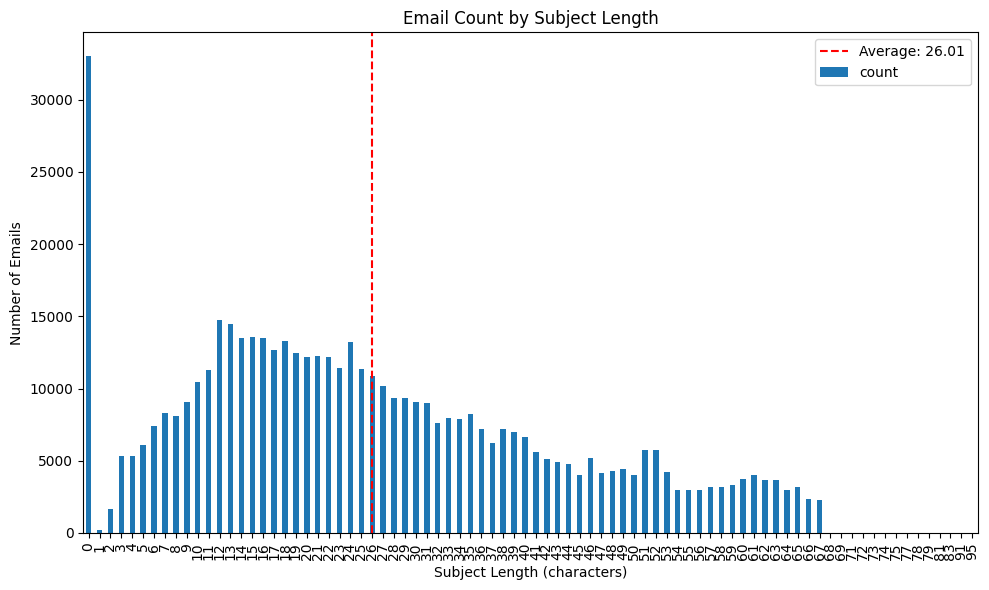

In [12]:
plt.figure(figsize=(10, 6))
subject_lengths.value_counts().sort_index().plot(kind='bar')
plt.title('Email Count by Subject Length')
plt.xlabel('Subject Length (characters)')
plt.ylabel('Number of Emails')
plt.axvline(x=avg_length, color='red', linestyle='--', label=f'Average: {avg_length:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

The rationale behind this is to train the LLM with more commonly used Subject Line lengths (30-50 chars according to most resources, I went for 20-60) so that its prediction remains consistent.

In [13]:
final_df = new_df[(new_df['subject'].str.len() >= 20) & (new_df['subject'].str.len() <= 60)]
final_df = final_df[final_df['body'].str.len() >= 50]

print(f"Original dataset size: {len(new_df)} emails")
print(f"Final dataset size: {len(final_df)} emails")
print(f"Percentage kept: {len(final_df)/len(new_df)*100:.2f}%")

Original dataset size: 517401 emails
Final dataset size: 273258 emails
Percentage kept: 52.81%


In [14]:
display(final_df.sample(5))

,subject,body
366408,CJ Melia San Lucas,Mine. Looks good. We should get one suite a...
197318,Merger Documentation-First Energy,I am being told that FirstEnergy Services Corp...
263102,something groovy fr. the Dali Lama,---------------------- Forwarded by Tori Kuyke...
95453,3 - URGENT - PLEASE PROCESS NOW!,Critical Migration Information:\n\n1. Your sch...
475218,Steel Trading - General Contacts,FYI\n----- Forwarded by Mark Taylor/HOU/ECT on...


# Split

Did not train and test on the whole dataset. But that can be easily done by uncommenting the two lines below

In [15]:
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Split into train (70%), validation (10%), and test (20%)
# train_df, temp_df = train_test_split(final_df, test_size=0.03, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.67, random_state=42)  # 0.67 * 0.3 = 0.2

small_df = final_df.sample(frac=0.015, random_state=42)
print(f"Using small subset of {len(small_df)} examples from {len(final_df)} total")

train_df, temp_df = train_test_split(small_df, test_size=0.33, random_state=42) 
val_df, test_df = train_test_split(temp_df, test_size=0.6, random_state=42) 

Using small subset of 4099 examples from 273258 total


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] Using device ➜ {device}")

def to_hf(df):
    return Dataset.from_pandas(df[["body", "subject"]]
                               .rename(columns={"body": "text", "subject": "label"}))

ds = DatasetDict({
    "train": to_hf(train_df),
    "validation": to_hf(val_df),
    "test": to_hf(test_df),
})

[15:05:31] Using device ➜ cuda


# Model Initialization

This is a simple summarization task. No need to overkill using Llama type billion param models. A simple text-to-text model should be sufficient.

In [17]:
model_ckpt = "t5-small"
tokenizer  = T5TokenizerFast.from_pretrained(model_ckpt)

MAX_IN  = 512
MAX_OUT = 32

def preprocess(batch):
    inp = ["summarize: " + t for t in batch["text"]]
    model_in = tokenizer(inp, truncation=True, padding="max_length",
                         max_length=MAX_IN)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["label"], truncation=True,
                           padding="max_length", max_length=MAX_OUT)
    model_in["labels"] = labels["input_ids"]
    return model_in

tokenised = ds.map(preprocess, batched=True, remove_columns=ds["train"].column_names)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/2746 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

In [18]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    # unwrap if Trainer packed things in a tuple
    if isinstance(preds, (tuple, list)):
        preds = preds[0]
        
    # Case A: (batch, seq_len, vocab)
    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)
    # Case B: (batch, seq_len) *but* still floats → one‑token logits
    elif np.issubdtype(preds.dtype, np.floating):
        preds = np.argmax(preds, axis=-1)
    # Now preds are integer token IDs
    preds = preds.astype(np.int32)
    labels = labels.astype(np.int32)
    labels[labels == -100] = tokenizer.pad_token_id
    
    # Get the vocabulary size and ensure all token IDs are valid
    vocab_size = tokenizer.vocab_size
    preds = np.clip(preds, 0, vocab_size - 1)
    labels = np.clip(labels, 0, vocab_size - 1)
    
    # Decode 
    pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge_scores = rouge.compute(predictions=pred_str, references=label_str, use_stemmer=True)
    exact = sum(p.lower() == l.lower() for p, l in zip(pred_str, label_str)) / len(label_str)
    return {"rougeL": rouge_scores["rougeL"], "exact_match": exact}


In [19]:
args = Seq2SeqTrainingArguments(
    output_dir          = "t5_email_subject",
    num_train_epochs    = 5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    learning_rate       = 5e-5,
    weight_decay        = 0.01,
    predict_with_generate = True,
    logging_strategy    = "steps",
    logging_steps       = 20,         
    logging_first_step  = True,
    eval_strategy = "epoch",
    save_strategy       = "epoch",
    fp16                = torch.cuda.is_available(), 
    report_to           = "none",     
)

model = T5ForConditionalGeneration.from_pretrained(model_ckpt).to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Train

In [20]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenised["train"],
    eval_dataset=tokenised["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] Starting training …")
trainer.train()
print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] Training finished!")

/tmp/ipykernel_19/1268260656.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


[15:05:40] Starting training …


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rougel,Exact Match
1,0.893800,0.763766,0.497505,0.268022
2,0.667900,0.710235,0.533409,0.317930
3,0.760300,0.690494,0.539473,0.327172
4,0.635800,0.684627,0.540087,0.323475
5,0.731600,0.683219,0.541519,0.323475


[15:11:59] Training finished!


# Comparison of Metrics

In [21]:
def simple_model_comparison():
    base_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
    
    # Same model parameters for a fair comparison
    generation_params = {
        "max_length": MAX_OUT,
        "num_beams": 4,
        "early_stopping": True
    }

    # Working...Now full test
    base_predictions = []
    finetuned_predictions = []
    actual_subjects = []
    
    # Also store full data for CSV export
    all_results = []
    
    print("Evaluating on full test set...")
    for i, (_, row) in enumerate(test_df.iterrows()):
        if i % 20 == 0:
            print(f"Processing example {i}/{len(test_df)}...")
            
        email_body = row['body']
        actual_subject = row['subject']
        actual_subjects.append(actual_subject)
        
        input_text = "summarize: " + email_body
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=MAX_IN, 
                           truncation=True, padding="max_length").input_ids.to(device)
        
        with torch.no_grad():
            base_output = base_model.generate(input_ids, **generation_params)
            base_subject = tokenizer.decode(base_output[0], skip_special_tokens=True)
            base_predictions.append(base_subject)
        
        with torch.no_grad():
            finetuned_output = trainer.model.generate(input_ids, **generation_params)
            finetuned_subject = tokenizer.decode(finetuned_output[0], skip_special_tokens=True)
            finetuned_predictions.append(finetuned_subject)
            
        # Store full data for CSV export
        all_results.append({
            'Body Excerpt': email_body[:150] + '...', 
            'Actual Subject': actual_subject,
            'Base Model': base_subject,
            'Fine-tuned Model': finetuned_subject
        })
    
    base_rouge = rouge.compute(predictions=base_predictions, references=actual_subjects, use_stemmer=True)
    finetuned_rouge = rouge.compute(predictions=finetuned_predictions, references=actual_subjects, use_stemmer=True)
    
    base_exact = sum(p.lower() == a.lower() for p, a in zip(base_predictions, actual_subjects)) / len(actual_subjects)
    finetuned_exact = sum(p.lower() == a.lower() for p, a in zip(finetuned_predictions, actual_subjects)) / len(actual_subjects)
    
    # Create and save results.txt file
    with open("results.txt", "w") as f:
        f.write("# Model Comparison Results\n\n")
        f.write("## Base T5-small metrics\n")
        f.write(f"rougeL         : {base_rouge['rougeL']:.4f}\n")
        f.write(f"exact_match    : {base_exact:.4f}\n\n")
        
        f.write("## Fine-tuned model metrics\n")
        f.write(f"rougeL         : {finetuned_rouge['rougeL']:.4f}\n")
        f.write(f"exact_match    : {finetuned_exact:.4f}\n\n")
        
        f.write("## Improvement\n")
        f.write(f"rougeL         : {finetuned_rouge['rougeL'] - base_rouge['rougeL']:.4f}\n")
        f.write(f"exact_match    : {finetuned_exact - base_exact:.4f}\n")
    
    # Save complete results to CSV
    complete_df = pd.DataFrame(all_results)
    complete_df.to_csv("output.csv", index=False)
    
    # Sample for display purposes
    sample_size = min(20, len(all_results))
    samples = all_results[:sample_size] 
    
    return {
        "samples": pd.DataFrame(samples),
        "metrics": {
            "base_rouge": base_rouge,
            "finetuned_rouge": finetuned_rouge,
            "base_exact": base_exact,
            "finetuned_exact": finetuned_exact
        }
    }
    


In [22]:
results = simple_model_comparison()


print("\n=== Base T5-small metrics ===")
print(f"rougeL         : {results['metrics']['base_rouge']['rougeL']:.4f}")
print(f"exact_match    : {results['metrics']['base_exact']:.4f}")

print("\n=== Fine-tuned model metrics ===")
print(f"rougeL         : {results['metrics']['finetuned_rouge']['rougeL']:.4f}")
print(f"exact_match    : {results['metrics']['finetuned_exact']:.4f}")

print("\n=== Improvement ===")
print(f"rougeL         : {results['metrics']['finetuned_rouge']['rougeL'] - results['metrics']['base_rouge']['rougeL']:.4f}")
print(f"exact_match    : {results['metrics']['finetuned_exact'] - results['metrics']['base_exact']:.4f}")

print("\nFiles created successfully:")
print("1. results.txt - Contains ROUGE and exact match metrics")
print("2. output.csv - Contains all test examples with predictions")

Evaluating on full test set...
Processing example 0/812...
Processing example 20/812...
Processing example 40/812...
Processing example 60/812...
Processing example 80/812...
Processing example 100/812...
Processing example 120/812...
Processing example 140/812...
Processing example 160/812...
Processing example 180/812...
Processing example 200/812...
Processing example 220/812...
Processing example 240/812...
Processing example 260/812...
Processing example 280/812...
Processing example 300/812...
Processing example 320/812...
Processing example 340/812...
Processing example 360/812...
Processing example 380/812...
Processing example 400/812...
Processing example 420/812...
Processing example 440/812...
Processing example 460/812...
Processing example 480/812...
Processing example 500/812...
Processing example 520/812...
Processing example 540/812...
Processing example 560/812...
Processing example 580/812...
Processing example 600/812...
Processing example 620/812...
Processing exam